# Transient Heat Transfer in Various Geometries

Transport of heat in a solid is described by the familiar thermal diffusion model

\begin{align}
\rho C_p\frac{\partial T}{\partial t} & = \nabla\cdot(k\nabla T)
\end{align}

We'll assume the thermal conductivity $k$ is a constant, and define thermal diffusivity in the conventional way

\begin{align}
\alpha & = \frac{k}{\rho C_p}
\end{align}

We will further assume symmetry with respect to all spatial coordinates except $r$ where $r$ extends from $-R$ to $+R$. The boundary conditions are

\begin{align}
T(t,R) & = T_{\infty} & \forall t > 0 \\
\nabla T(t,0) & = 0 & \forall t \geq 0 
\end{align}

where we have assumed symmetry with respect to $r$ and uniform initial conditions $T(0, r) = T_0$ for all $0 \leq r \leq R$. Following standard scaling procedures, we introduce the dimensionless variables

\begin{align}
T' & = \frac{T - T_0}{T_\infty - T_0} \\
r' & = \frac{r}{R} \\
t' & = t \frac{\alpha}{R^2}
\end{align}

Under these conditions the problem reduces to 

\begin{align}
\frac{\partial T'}{\partial t'} & = \nabla^2 T'
\end{align}

with auxiliary conditions

\begin{align}
T'(t', 1) & = 1 & \forall t' > 0\\
\nabla T'(t', 0) & = 0 & \forall t' \geq 0 \\
T'(0, r') & = 0 & \forall 0 \leq r' \leq 1
\end{align}

We now create models for specific geometries.

## Slab

Suppressing the prime notation, for a slab geometry the model specializes to 

\begin{align}
\frac{\partial T}{\partial t} & = \frac{\partial^2 T}{\partial r^2}
\end{align}

with auxiliary conditions

\begin{align}
T(t, 1) & = 1 & \forall t > 0\\
\frac{\partial T}{\partial r} (t, 0) & = 0 & \forall t \geq 0 \\
T(0, r) & = 0 & \forall 0 \leq r \leq 1
\end{align}

In [34]:
from pyomo.environ import *
from pyomo.dae import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

m = ConcreteModel()

m.r = ContinuousSet(bounds=(0,1))
m.t = ContinuousSet(bounds=(0,10))

m.T = Var(m.t, m.r)

m.dTdt = DerivativeVar(m.T, wrt=m.t)
m.dTdr = DerivativeVar(m.T, wrt=m.r)
m.d2Tdr2 = DerivativeVar(m.T, wrt=(m.r, m.r))

m.pde = Constraint(m.t, m.r, rule=
    lambda m, t, r: m.dTdt[t,r] == m.d2Tdr2[t,r] if t > 0 and r > 0 and r < 1 else Constraint.Skip)

m.bc1 = Constraint(m.t, rule=lambda m, t: m.T[t,1] == 1 if t > 0 else Constraint.Skip)
m.bc2 = Constraint(m.t, rule=lambda m, t: m.dTdr[t,0] == 0)
m.ic  = Constraint(m.r, rule=lambda m, r: m.T[0,r] == 0)

TransformationFactory('dae.finite_difference').apply_to(m, nfe=20, wrt=m.r, scheme='CENTRAL')
TransformationFactory('dae.finite_difference').apply_to(m, nfe=100, wrt=m.t, scheme='BACKWARD')
SolverFactory('ipopt').solve(m).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 8060
  Number of variables: 8160
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.8\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.4899919033050537
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


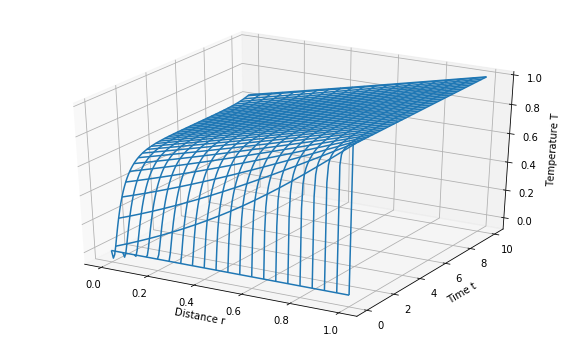

In [37]:
r = sorted(m.r)
t = sorted(m.t)

rgrid = np.zeros((len(t), len(r)))
tgrid = np.zeros((len(t), len(r)))
Tgrid = np.zeros((len(t), len(r)))

for i in range(0, len(t)):
    for j in range(0, len(r)):
        rgrid[i,j] = r[j]
        tgrid[i,j] = t[i]
        Tgrid[i,j] = m.T[t[i], r[j]].value

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_xlabel('Distance r')
ax.set_ylabel('Time t')
ax.set_zlabel('Temperature T')
p = ax.plot_wireframe(rgrid, tgrid, Tgrid)